In [51]:
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gnn_scheduler.utils import get_data_path

DATA_PATH = get_data_path()
EXPERIMENT_NUMBERS_TO_USE = [5, 24, 40]
USE_ALL_EXPERIMENTS = False
USE_PDRS = True
USE_SOTA = False
SELECTED_EXPERIMENTS = [
    f"experiment{"_" if num < 10 else ""}{num}{"_run_1" if num == 40 else ""}_results.csv"
    for num in EXPERIMENT_NUMBERS_TO_USE
]
EXPERIMENT_RESULTS = [
    f
    for f in pathlib.Path(DATA_PATH).glob("experiment*_results.csv")
    if f.is_file() and USE_ALL_EXPERIMENTS or f.name in SELECTED_EXPERIMENTS
]
EXPERIMENT_RESULTS

[PosixPath('/home/pablo/VSCodeProjects/gnn_scheduler/data/experiment40_run_1_results.csv'),
 PosixPath('/home/pablo/VSCodeProjects/gnn_scheduler/data/experiment24_results.csv'),
 PosixPath('/home/pablo/VSCodeProjects/gnn_scheduler/data/experiment_5_results.csv')]

In [52]:
dfs = [
    pd.read_csv(
        csv_file,
        usecols=[0, 3],
        index_col=0,
        skiprows=1,
        names=[
            "instance_name",
            f"makespan_{csv_file.stem.replace('_results', '')}",
        ],
    )
    for csv_file in sorted(EXPERIMENT_RESULTS)
]
if USE_SOTA:
    sota_makespans = pd.read_csv(
        DATA_PATH / "sota_makespans.csv",
        index_col=0,
    )
    dfs.append(sota_makespans)
if USE_PDRS:
    pdrs_makespans = pd.read_csv(
        DATA_PATH / "pdrs_results.csv",
        index_col=0,
    )
    dfs.append(pdrs_makespans)
dfs_merged = pd.concat(dfs, axis=1)
first_df = pd.read_csv(EXPERIMENT_RESULTS[0], index_col=0)
dfs_merged["makespan_best_known"] = first_df["upper_bound"]
dfs_merged["num_machines"] = first_df["num_machines"]
dfs_merged["num_jobs"] = first_df["num_jobs"]
# size = f"{num_jobs} x {num_machines}"
dfs_merged["size"] = (
    dfs_merged["num_jobs"].astype(str)
    + "x"
    + dfs_merged["num_machines"].astype(str)
)
# Add a column with the index first two chars
dfs_merged["benchmark"] = dfs_merged.index.str[:2]

# Remove columns that contain "ScheduleNet's"
columns_to_drop = [col for col in dfs_merged.columns if "ScheduleNet's" in col]
dfs_merged = dfs_merged.drop(columns=columns_to_drop)

# Change "instance_name" to "Instance name" as the index name
dfs_merged.index.name = "Instance name"

# Add optimilaity gaps columns comparing to the best known makespan
for col in dfs_merged.columns:
    if "makespan" in col and "best_known" not in col:
        dfs_merged[col.replace("makespan", "gap")] = (
            dfs_merged[col] - dfs_merged["makespan_best_known"]
        ) / dfs_merged["makespan_best_known"]
dfs_merged.head()

makespans = dfs_merged.filter(like="makespan")
optimality_gaps = dfs_merged.filter(like="gap")

mapping = {
    "experiment_5": "Non-MP (Ours)",
    "experiment24": "RGIN (Ours)",
    "experiment40_run_1": "RGATv2 (Ours)",
    "_rs": "_RS",
    "lee": "Lee (2024)",
    "schedulenet": "ScheduleNet",
    "l2s": "L2S",
    "l2d": "L2D",
    "_mor": "'s MOR",
    "_fifo": "'s FCFS",
    "_spt": "'s SPT",
    "best_known": "Best known",
    "makespan_": "",
    "random": "Random",
}
# Rename the columns by replacing the keys with the values in the mapping
# using str.replace
for key, value in mapping.items():
    dfs_merged.columns = dfs_merged.columns.str.replace(
        key, value, regex=False
    )
    makespans.columns = makespans.columns.str.replace(key, value, regex=False)
    optimality_gaps.columns = optimality_gaps.columns.str.replace(
        key, value, regex=False
    )

In [ ]:
# Get the styled DataFrame ready for LaTeX export
def make_latex_table(df, caption="Makespan results", label="tab:makespans"):
    """
    Convert a pandas DataFrame to a formatted LaTeX table.

    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to convert
    caption : str
        The table caption
    label : str
        The table label for cross-referencing

    Returns:
    --------
    str
        LaTeX table code
    """
    # Make a copy to avoid modifying the original
    styled_df = df.copy()

    # Format the makespans as integers
    for col in styled_df.columns:
        if col != "random":
            styled_df[col] = styled_df[col].astype(int)

    # Bold the minimum makespan per row, excluding 'Best known'
    min_cols = styled_df.drop(columns=["Best known"]).idxmin(axis=1)
    previous_prefix: str | None = None
    for idx, col in min_cols.items():
        current_prefix = idx[:2]
        # Bold the minimum makespan
        styled_df.at[idx, col] = f"\\textbf{{{styled_df.at[idx, col]}}}"
        if previous_prefix is None:
            previous_prefix = current_prefix
        elif current_prefix != previous_prefix:
            # Add hline between different benchmarks
            styled_df.at[idx, col] = "\\hline " + styled_df.at[idx, col]
            previous_prefix = current_prefix

    # Generate LaTeX code
    latex_code = styled_df.to_latex(
        float_format="%.1f",  # Format for float columns
        caption=caption,
        label=label,
        position="H",
        escape=False,
        longtable=False,
        index=True,
    )

    return latex_code


# Generate and print the LaTeX table code
latex_table = make_latex_table(makespans)

# Add hline between different benchmarks
latex_table = [line for line in latex_table.split("\n")]
new_latex_table = []
for line in latex_table:
    if "\\hline" in line:
        new_latex_table.append("\\hline")
    new_latex_table.append(line.replace("\\hline", ""))

latex_table = "\n".join(new_latex_table)
print(latex_table)
# Optionally save to a file
with open(DATA_PATH / "makespans_table.tex", "w") as f:
    f.write(latex_table)

In [53]:
# Calculate the mean of each numeric column and sort the results
numeric_columns = dfs_merged.select_dtypes(include="number").columns
dfs_merged[numeric_columns].mean().sort_values()

gap_RGATv2 (Ours)       0.119226
gap_Non-MP (Ours)       0.144278
gap_RGIN (Ours)         0.149577
gap_MWKR                0.191923
gap_FCFS                0.209314
gap_MOR                 0.209314
gap_SPT                 0.250448
gap_Random              0.287465
num_machines           13.833333
num_jobs               29.759259
Best known           1835.574074
RGATv2 (Ours)        2023.098765
Non-MP (Ours)        2076.598765
RGIN (Ours)          2086.191358
MWKR                 2169.771605
MOR                  2200.901235
FCFS                 2200.901235
SPT                  2267.549383
Random               2338.056790
dtype: float64

In [40]:
def create_optimality_gap_plot(
    df_plot_source: pd.DataFrame,
    valid_experiments_for_plot: list[str],
    display_name_map: dict[str, str],
    plot_style: str = "ggplot",
    figure_size: tuple[int, int] = (12, 6),
    bar_group_width_ratio: float = 0.8,
    bar_padding_ratio: float = 0.95,
    our_experiment_hatch: str = "////",
    our_experiment_identifier: str = "(Ours)",
    y_label: str = "Average Optimality Gap",
    x_label: str = "Size",
    plot_title: str = "",
    legend_title: str = "",
    legend_loc: str = "upper right",
    xtick_label_rotation: int = 0,
    xtick_label_ha: str = "center",
):
    """
    Generates and saves a bar plot of optimality gaps.

    Args:
        df_plot_source (pd.DataFrame): DataFrame with benchmark instances as index
                                       and experiments as columns, containing gap values.
        valid_experiments_for_plot (list[str]): Ordered list of experiment names to plot.
        display_name_map (dict[str, str]): Mapping from internal experiment names to display names.
        plot_style (str, optional): Matplotlib style to use. Defaults to "ggplot".
        figure_size (tuple[int, int], optional): Size of the figure. Defaults to (12, 6).
        bar_group_width_ratio (float, optional): Ratio of total width for bars in a group. Defaults to 0.8.
        bar_padding_ratio (float, optional): Padding between bars within a group. Defaults to 0.95.
        our_experiment_hatch (str, optional): Hatch pattern for 'our' experiments. Defaults to "////".
        our_experiment_identifier (str, optional): String in display name to identify 'our' experiments.
                                                 Defaults to "(Ours)".
        y_label (str, optional): Label for the y-axis. Defaults to "Average Optimality Gap".
        x_label (str, optional): Label for the x-axis. Defaults to "Size".
        plot_title (str, optional): Title of the plot. Defaults to "".
        legend_title (str, optional): Title for the legend. Defaults to "".
        legend_loc (str, optional): Location of the legend. Defaults to "upper right".
        xtick_label_rotation (int, optional): Rotation for x-axis tick labels. Defaults to 0.
        xtick_label_ha (str, optional): Horizontal alignment for x-axis tick labels. Defaults to "center".
    """
    if df_plot_source.empty:
        print("Warning: df_plot_source is empty. Plot will not be generated.")
        return

    plt.style.use(plot_style)
    fig, ax = plt.subplots(figsize=figure_size)

    num_benchmark_groups = len(df_plot_source.index)
    max_bars_per_group = len(valid_experiments_for_plot)

    group_center_positions = np.arange(num_benchmark_groups)
    bar_width = (
        bar_group_width_ratio / max_bars_per_group
        if max_bars_per_group > 0
        else bar_group_width_ratio
    )

    color_palette = plt.cm.get_cmap("tab10").colors
    experiment_color_map = {
        exp_name: color_palette[i % len(color_palette)]
        for i, exp_name in enumerate(valid_experiments_for_plot)
    }

    for i, benchmark_name in enumerate(df_plot_source.index):
        current_benchmark_gaps = df_plot_source.loc[benchmark_name]
        current_benchmark_gaps_no_nan = current_benchmark_gaps.dropna()
        sorted_gaps_for_benchmark = current_benchmark_gaps_no_nan.sort_values()
        num_bars_in_this_group = len(sorted_gaps_for_benchmark)

        if num_bars_in_this_group == 0:
            continue

        for j, (experiment_name, gap_value) in enumerate(
            sorted_gaps_for_benchmark.items()
        ):
            bar_offset_from_group_center = (
                j - (num_bars_in_this_group - 1) / 2.0
            ) * bar_width
            actual_bar_position = (
                group_center_positions[i] + bar_offset_from_group_center
            )

            current_display_name = display_name_map.get(
                experiment_name, experiment_name
            )
            hatch_pattern = None
            if our_experiment_identifier in current_display_name:
                hatch_pattern = our_experiment_hatch

            ax.bar(
                actual_bar_position,
                gap_value,
                width=bar_width * bar_padding_ratio,
                color=experiment_color_map.get(experiment_name, "gray"),
                align="center",
                hatch=hatch_pattern,
            )

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(plot_title)
    ax.set_xticks(group_center_positions)

    x_tick_labels_display: list[str] = []
    if num_benchmark_groups > 0:
        x_tick_labels_display = [
            name.split("_", 1)[1] if "_" in name else name
            for name in df_plot_source.index
        ]
    ax.set_xticklabels(
        x_tick_labels_display, rotation=xtick_label_rotation, ha=xtick_label_ha
    )

    ax.grid(True)

    if valid_experiments_for_plot:
        legend_handles: list[plt.Rectangle] = []
        legend_labels_display: list[str] = []
        for exp_key in valid_experiments_for_plot:
            display_name = display_name_map.get(exp_key, exp_key)
            legend_labels_display.append(display_name)

            hatch_pattern_legend = None
            if our_experiment_identifier in display_name:
                hatch_pattern_legend = our_experiment_hatch

            rect = plt.Rectangle(
                (0, 0),
                1,
                1,
                facecolor=experiment_color_map.get(exp_key, "gray"),
                hatch=hatch_pattern_legend,
                edgecolor="white",
            )
            legend_handles.append(rect)

        ax.legend(
            legend_handles,
            legend_labels_display,
            title=legend_title,
            loc=legend_loc,
        )

    plt.tight_layout()
    return fig, ax

In [54]:
# Remove "gap_" prefix from the column names
optimality_gaps.columns = optimality_gaps.columns.str.replace(
    "gap_", "", regex=False
)
optimality_gaps

,RGIN (Ours),RGATv2 (Ours),Non-MP (Ours),SPT,FCFS,MWKR,MOR,Random
Instance name,,,,,,,,
abz5,0.175041,0.116694,0.052674,0.095624,0.082658,0.109400,0.082658,0.213938
abz6,0.041357,0.143160,0.063627,0.163309,0.093319,0.046660,0.093319,0.155037
abz7,0.169207,0.149390,0.250000,0.294207,0.181402,0.172256,0.181402,0.265549
abz8,0.239098,0.150376,0.249624,0.396992,0.218045,0.240602,0.218045,0.357594
abz9,0.196165,0.148968,0.206490,0.308260,0.325959,0.264012,0.325959,0.313569
...,...,...,...,...,...,...,...,...
ta76,0.085361,0.054287,0.093972,0.192437,0.111194,0.102022,0.111194,0.146687
ta77,0.033113,0.023915,0.049669,0.112031,0.072296,0.086277,0.072296,0.155997
ta78,0.028736,0.001854,0.023545,0.138858,0.091212,0.056730,0.091212,0.150649


In [55]:
# Select only the rows which index starts with "ta"
optimality_gaps_ta = optimality_gaps[optimality_gaps.index.str.startswith("ta")]
optimality_gaps_ta

,RGIN (Ours),RGATv2 (Ours),Non-MP (Ours),SPT,FCFS,MWKR,MOR,Random
Instance name,,,,,,,,
ta01,0.151909,0.185215,0.132413,0.187652,0.168156,0.211210,0.168156,0.261089
ta02,0.239550,0.122186,0.228296,0.162379,0.167203,0.157556,0.167203,0.343248
ta03,0.208539,0.185550,0.124795,0.227422,0.164204,0.170772,0.164204,0.355501
ta04,0.197447,0.240851,0.275745,0.453617,0.240000,0.180426,0.240000,0.338213
ta05,0.244281,0.232843,0.119281,0.321895,0.183007,0.220588,0.183007,0.340196
...,...,...,...,...,...,...,...,...
ta76,0.085361,0.054287,0.093972,0.192437,0.111194,0.102022,0.111194,0.146687
ta77,0.033113,0.023915,0.049669,0.112031,0.072296,0.086277,0.072296,0.155997
ta78,0.028736,0.001854,0.023545,0.138858,0.091212,0.056730,0.091212,0.150649


In [56]:
# Remove columns that contain "ScheduleNet's"
columns_to_drop = [col for col in optimality_gaps_ta.columns if "ScheduleNet's" in col]
optimality_gaps_ta = optimality_gaps_ta.drop(columns=columns_to_drop)
optimality_gaps_ta

,RGIN (Ours),RGATv2 (Ours),Non-MP (Ours),SPT,FCFS,MWKR,MOR,Random
Instance name,,,,,,,,
ta01,0.151909,0.185215,0.132413,0.187652,0.168156,0.211210,0.168156,0.261089
ta02,0.239550,0.122186,0.228296,0.162379,0.167203,0.157556,0.167203,0.343248
ta03,0.208539,0.185550,0.124795,0.227422,0.164204,0.170772,0.164204,0.355501
ta04,0.197447,0.240851,0.275745,0.453617,0.240000,0.180426,0.240000,0.338213
ta05,0.244281,0.232843,0.119281,0.321895,0.183007,0.220588,0.183007,0.340196
...,...,...,...,...,...,...,...,...
ta76,0.085361,0.054287,0.093972,0.192437,0.111194,0.102022,0.111194,0.146687
ta77,0.033113,0.023915,0.049669,0.112031,0.072296,0.086277,0.072296,0.155997
ta78,0.028736,0.001854,0.023545,0.138858,0.091212,0.056730,0.091212,0.150649


In [57]:
# Group optimality_gaps_ta by the instance size (from dfs_merged)
optimality_gaps_ta_grouped = (
    optimality_gaps_ta.groupby(dfs_merged["size"])
    .mean()
    .sort_index(ascending=True)
)
optimality_gaps_ta_grouped

,RGIN (Ours),RGATv2 (Ours),Non-MP (Ours),SPT,FCFS,MWKR,MOR,Random
size,,,,,,,,
100x20,0.055001,0.023654,0.050408,0.144081,0.091523,0.083060,0.091523,0.166804
15x15,0.214947,0.185440,0.179567,0.258888,0.205323,0.191523,0.205323,0.314421
20x15,0.208838,0.170211,0.204368,0.328259,0.235608,0.233584,0.235608,0.340083
20x20,0.213202,0.187619,0.189772,0.277518,0.217076,0.218130,0.217076,0.331268
30x15,0.222180,0.161464,0.183696,0.352658,0.228222,0.239064,0.228222,0.348619
30x20,0.247692,0.184952,0.207745,0.344063,0.249099,0.251397,0.249099,0.371254
50x15,0.121699,0.073921,0.119247,0.241089,0.173661,0.168598,0.173661,0.253822
50x20,0.157050,0.101884,0.136912,0.255396,0.176843,0.179467,0.176843,0.302431


In [58]:
wheatley_optimality_gap = {
    "15x15": 0.172,
    "20x15": 0.16899999999999998,
    "20x20": 0.249,
    "30x10": 0.055,
    "30x15": 0.145,
    "30x20": 0.22,
    "50x15": 0.083,
    "50x20": 0.149,
    "100x20": 0.069,
}
# Add Wheatley optimality gaps to the grouped DataFrame
optimality_gaps_ta_grouped["Wheatley"] = pd.Series(
    wheatley_optimality_gap, index=optimality_gaps_ta_grouped.index
)
optimality_gaps_ta_grouped

,RGIN (Ours),RGATv2 (Ours),Non-MP (Ours),SPT,FCFS,MWKR,MOR,Random,Wheatley
size,,,,,,,,,
100x20,0.055001,0.023654,0.050408,0.144081,0.091523,0.083060,0.091523,0.166804,0.069
15x15,0.214947,0.185440,0.179567,0.258888,0.205323,0.191523,0.205323,0.314421,0.172
20x15,0.208838,0.170211,0.204368,0.328259,0.235608,0.233584,0.235608,0.340083,0.169
20x20,0.213202,0.187619,0.189772,0.277518,0.217076,0.218130,0.217076,0.331268,0.249
30x15,0.222180,0.161464,0.183696,0.352658,0.228222,0.239064,0.228222,0.348619,0.145
30x20,0.247692,0.184952,0.207745,0.344063,0.249099,0.251397,0.249099,0.371254,0.220
50x15,0.121699,0.073921,0.119247,0.241089,0.173661,0.168598,0.173661,0.253822,0.083
50x20,0.157050,0.101884,0.136912,0.255396,0.176843,0.179467,0.176843,0.302431,0.149


In [59]:
def size_str_to_tuple(size_str: str) -> tuple[int, int]:
    """
    Convert a size string (e.g., "10x5") to a tuple of integers (10, 5).
    """
    num_jobs, num_machines = map(int, size_str.split("x"))
    return num_jobs, num_machines


# Sort the index of optimality_gaps_ta_grouped by the index in ascending order
optimality_gaps_ta_grouped = optimality_gaps_ta_grouped.reindex(
    sorted(optimality_gaps_ta_grouped.index, key=size_str_to_tuple)
)
optimality_gaps_ta_grouped

,RGIN (Ours),RGATv2 (Ours),Non-MP (Ours),SPT,FCFS,MWKR,MOR,Random,Wheatley
size,,,,,,,,,
15x15,0.214947,0.185440,0.179567,0.258888,0.205323,0.191523,0.205323,0.314421,0.172
20x15,0.208838,0.170211,0.204368,0.328259,0.235608,0.233584,0.235608,0.340083,0.169
20x20,0.213202,0.187619,0.189772,0.277518,0.217076,0.218130,0.217076,0.331268,0.249
30x15,0.222180,0.161464,0.183696,0.352658,0.228222,0.239064,0.228222,0.348619,0.145
30x20,0.247692,0.184952,0.207745,0.344063,0.249099,0.251397,0.249099,0.371254,0.220
50x15,0.121699,0.073921,0.119247,0.241089,0.173661,0.168598,0.173661,0.253822,0.083
50x20,0.157050,0.101884,0.136912,0.255396,0.176843,0.179467,0.176843,0.302431,0.149
100x20,0.055001,0.023654,0.050408,0.144081,0.091523,0.083060,0.091523,0.166804,0.069


In [60]:
optimality_gaps_ta_grouped.to_csv(
    DATA_PATH / "optimality_gaps_ta_grouped_with_sota.csv",
    index=True,
    header=True,
)

In [68]:
def create_latex_table_with_bold_min(df, caption="Optimality Gap Results", label="tab:optimality_gaps"):
    """
    Create a LaTeX table from the dataframe with the minimum value in each row bolded.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame to convert
    caption : str
        The table caption
    label : str
        The table label for cross-referencing
        
    Returns:
    --------
    str
        LaTeX table code
    """
    # Make a copy to avoid modifying the original
    styled_df = df.copy()

    # Format all values to 4 decimal places first
    for idx in styled_df.index:
        for col in styled_df.columns:
            if isinstance(styled_df.at[idx, col], (int, float)):
                styled_df.at[idx, col] = f"{styled_df.at[idx, col]:.4f}"

    # For each row, find the minimum value and make it bold
    for idx in styled_df.index:
        # Convert all string values back to float for comparison
        row_vals = {col: float(val) for col, val in styled_df.loc[idx].items() if not col == 'size'}
        if row_vals:
            min_val = min(row_vals.values())
            # Find all columns that have the minimum value
            min_cols = [col for col, val in row_vals.items() if abs(float(val) - min_val) < 1e-10]

            if min_cols:
                # Bold the first column with minimum value
                min_col = min_cols[0]
                styled_df.at[idx, min_col] = f"\\textbf{{{styled_df.at[idx, min_col]}}}"

    # Generate LaTeX code
    latex_code = styled_df.to_latex(
        caption=caption,
        label=label,
        position="H",
        escape=False,
        longtable=False,
        index=False
    )

    return latex_code


# Apply the function to the dataframe and print the result
print(
    create_latex_table_with_bold_min(
        optimality_gaps_ta_grouped.reset_index().drop(
            columns=["FCFS", "Wheatley"], errors="ignore"
        ),
        caption="Average Optimality Gap on Taillard Instances by Size",
        label="tab:optimality_gaps_ta",
    )
)

\begin{table}[H]
\caption{Average Optimality Gap on Taillard Instances by Size}
\label{tab:optimality_gaps_ta}
\begin{tabular}{llllllll}
\toprule
size & RGIN (Ours) & RGATv2 (Ours) & Non-MP (Ours) & SPT & MWKR & MOR & Random \\
\midrule
15x15 & 0.2149 & 0.1854 & \textbf{0.1796} & 0.2589 & 0.1915 & 0.2053 & 0.3144 \\
20x15 & 0.2088 & \textbf{0.1702} & 0.2044 & 0.3283 & 0.2336 & 0.2356 & 0.3401 \\
20x20 & 0.2132 & \textbf{0.1876} & 0.1898 & 0.2775 & 0.2181 & 0.2171 & 0.3313 \\
30x15 & 0.2222 & \textbf{0.1615} & 0.1837 & 0.3527 & 0.2391 & 0.2282 & 0.3486 \\
30x20 & 0.2477 & \textbf{0.1850} & 0.2077 & 0.3441 & 0.2514 & 0.2491 & 0.3713 \\
50x15 & 0.1217 & \textbf{0.0739} & 0.1192 & 0.2411 & 0.1686 & 0.1737 & 0.2538 \\
50x20 & 0.1571 & \textbf{0.1019} & 0.1369 & 0.2554 & 0.1795 & 0.1768 & 0.3024 \\
100x20 & 0.0550 & \textbf{0.0237} & 0.0504 & 0.1441 & 0.0831 & 0.0915 & 0.1668 \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_33637/2012424610.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2149' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styled_df.at[idx, col] = f"{styled_df.at[idx, col]:.4f}"
/tmp/ipykernel_33637/2012424610.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1854' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styled_df.at[idx, col] = f"{styled_df.at[idx, col]:.4f}"
/tmp/ipykernel_33637/2012424610.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1796' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styled_df.at[idx, col] = f"{styled_df.at[idx, col]:.4f}"
/tmp/ipykernel_33637/2012424

/tmp/ipykernel_33637/1888256937.py:59: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap("tab10").colors


UFuncTypeError: ufunc 'less' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

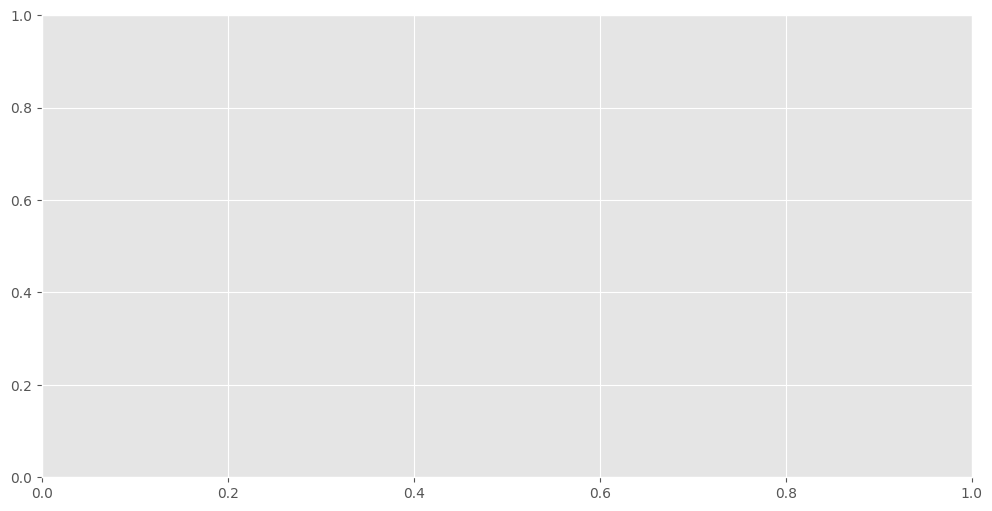

In [ ]:
fig, ax = create_optimality_gap_plot(
    df_plot_source=dfs_merged,
    valid_experiments_for_plot=[
        "Non-MP (Ours)",
        "RGATv2 (Ours)",
        "RGIN (Ours)",
        "ScheduleNet",
        "Lee (2024)",
        "L2S",
        "L2D",
    ],
    display_name_map=mapping,
    plot_style="ggplot",
    figure_size=(12, 6),
    bar_group_width_ratio=0.8,
    bar_padding_ratio=0.95,
    our_experiment_hatch="////",
    our_experiment_identifier="(Ours)",
    y_label="Average Optimality Gap",
    x_label="Size",
    plot_title="Average Optimality Gap of Different Experiments",
    legend_title="Experiments",
)